In [17]:
!pip install matplotlib


     |████████████████████████████████| 7.8 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 11.7 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 9.5 MB/s  eta 0:00:01
     |████████████████████████████████| 2.8 MB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 249 kB 14.3 MB/s eta 0:00:01
You should consider upgrading via the '/Users/paidamoyo/Documents/WRN-CIFAR10-Reproduction-/venv/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip install torch torchvision


     |████████████████████████████████| 68.6 MB 6.9 MB/s eta 0:00:011
     |████████████████████████████████| 1.9 MB 12.7 MB/s eta 0:00:01
     |████████████████████████████████| 6.3 MB 12.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 194 kB 15.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 13.7 MB/s eta 0:00:01
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl (5.3 MB)
     |████████████████████████████████| 536 kB 11.5 MB/s eta 0:00:01
You should consider upgrading via the '/Users/paidamoyo/Documents/WRN-CIFAR10-Reproduction-/venv/bin/python3 -m pip install --upgrade pip' command.


In [12]:
!pip install tqdm

     |████████████████████████████████| 78 kB 2.7 MB/s eta 0:00:01
You should consider upgrading via the '/Users/paidamoyo/Documents/WRN-CIFAR10-Reproduction-/venv/bin/python3 -m pip install --upgrade pip' command.


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

## Defining the Basic Block (Residual Block)

In [19]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, drop_rate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.drop_rate = drop_rate
        self.equalInOut = (in_planes == out_planes)
        self.shortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes,
                                                            kernel_size=1, stride=stride,
                                                            padding=0, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
        out = self.conv2(out)
        return out + (x if self.equalInOut else self.shortcut(x))


## Defining Network Block (a group of residual blocks)

In [20]:
class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, drop_rate):
        super(NetworkBlock, self).__init__()
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes,
                                out_planes,
                                i == 0 and stride or 1,
                                drop_rate))
        self.layer = nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


## Defining the WideResNet

In [21]:
class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor=10, num_classes=10, drop_rate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert ((depth - 4) % 6 == 0)
        n = (depth - 4) // 6

        block = BasicBlock
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, drop_rate)
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, drop_rate)
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, drop_rate)
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, out.size()[2:])  # Global average pooling
        out = out.view(out.size(0), -1)
        return self.fc(out)


## Test the Model with Dummy Data

In [22]:
# Instantiating the model
model = WideResNet(depth=28, widen_factor=10, num_classes=10)
print("✅ WRN-28-10 model created!")

#  dummy input Test
x = torch.randn(1, 3, 32, 32)  # CIFAR-10 image size
y = model(x)
print(f"Output shape: {y.shape}")  # Should be [1, 10]


✅ WRN-28-10 model created!
Output shape: torch.Size([1, 10])


## Loading CIFAR-10 (same transforms as Cynthia used)

In [23]:


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


## Model Initialization + Optimizer Setup

In [24]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = WideResNet(depth=28, widen_factor=10, num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)


## Training & Testing Functions

In [25]:


def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch}")
    for data, target in loop:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100.*correct/total)

def test(model, device, test_loader, criterion):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss += criterion(outputs, target).item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(target).sum().item()

    loss /= len(test_loader)
    acc = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n")
    return loss, acc


## Running the Training Loop

In [26]:
epochs = 10
test_accs = []

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch)
    _, test_acc = test(model, device, test_loader, criterion)
    test_accs.append(test_acc)
    scheduler.step()


Epoch 1: 100%|█████████| 391/391 [3:51:16<00:00, 35.49s/it, acc=47.2, loss=1.07]



Test set: Average loss: 1.3396, Accuracy: 5290/10000 (52.90%)



Epoch 2: 100%|████████| 391/391 [1:05:18<00:00, 10.02s/it, acc=68.3, loss=0.841]



Test set: Average loss: 0.9246, Accuracy: 6798/10000 (67.98%)



Epoch 3: 100%|████████| 391/391 [1:09:29<00:00, 10.66s/it, acc=75.8, loss=0.531]



Test set: Average loss: 0.7564, Accuracy: 7361/10000 (73.61%)



Epoch 4: 100%|████████| 391/391 [1:09:51<00:00, 10.72s/it, acc=79.3, loss=0.458]



Test set: Average loss: 1.0349, Accuracy: 6672/10000 (66.72%)



Epoch 5: 100%|██████| 391/391 [12:50:47<00:00, 118.28s/it, acc=81.8, loss=0.616]



Test set: Average loss: 0.6289, Accuracy: 7812/10000 (78.12%)



Epoch 6: 100%|████████| 391/391 [4:37:05<00:00, 42.52s/it, acc=86.9, loss=0.436]



Test set: Average loss: 0.4705, Accuracy: 8359/10000 (83.59%)



Epoch 7: 100%|████████| 391/391 [2:56:28<00:00, 27.08s/it, acc=87.6, loss=0.223]



Test set: Average loss: 0.5065, Accuracy: 8276/10000 (82.76%)



Epoch 8: 100%|████████| 391/391 [1:03:58<00:00,  9.82s/it, acc=88.5, loss=0.347]



Test set: Average loss: 0.4954, Accuracy: 8299/10000 (82.99%)



Epoch 9: 100%|████████| 391/391 [1:03:23<00:00,  9.73s/it, acc=88.9, loss=0.294]



Test set: Average loss: 0.4729, Accuracy: 8435/10000 (84.35%)



Epoch 10: 100%|█████| 391/391 [13:10:03<00:00, 121.24s/it, acc=89.4, loss=0.432]



Test set: Average loss: 0.4443, Accuracy: 8456/10000 (84.56%)



## Plot Accuracy Over Epochs

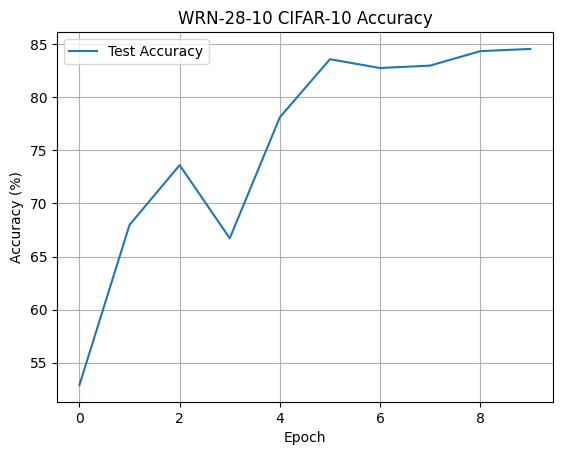

In [27]:


plt.plot(test_accs, label='Test Accuracy')
plt.title('WRN-28-10 CIFAR-10 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()
